# How to create a  video story from text with Artificial Intelligence

Hello everyone, today we are going to create a simple application that will generate a video from a text with images generated with Artificial Intellingence.

This just an introduction of the amazing world of the generation of syntetic images.

The technique is based on generative adversarial network (GAN) is a machine learning (ML) wmodel in which two neural networks compete with each other to become more accurate in their predictions.







# Step 1 - Libraries Installation

The application that we will use will perform a summary of the text that you will introduce by sing the BART-Model and the generation of the Images will be produced by Dalle-Mini. 

- Dalle mini is a free, open-source AI that produces amazing images from text inputs.

- The BART Model with a language modeling head. Can be used for summarization. This model inherits from PreTrainedModel.

In [1]:
#pip install min-dalle
# Step 2 - Importing Libraries
from moviepy.editor import *
from PIL import Image
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,pipeline
import gradio as gr
import torch
from huggingface_hub import snapshot_download
from PIL import Image
import torch
from PIL import Image, ImageDraw, ImageFont
import textwrap
from mutagen.mp3 import MP3
# to speech conversion
from gtts import gTTS
from pydub import AudioSegment
from os import getcwd
import glob
import nltk
import subprocess
from IPython.display import display, update_display
from min_dalle import MinDalle
nltk.download('punkt')
description = " Video Story Generator with Audio \n PS:  Generation of video by using Artifical Intellingence by dalle-mini and distilbart and gtss "
title = "Video Story Generator with Audio by using dalle-mini and distilbart and gtss  "

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Analsis of GPU usage
def log_gpu_memory():
    print(subprocess.check_output('nvidia-smi').decode('utf-8'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_gpu = True if torch.cuda.is_available() else False
# We check our initial status of our GPU memory
if use_gpu == True : log_gpu_memory() 
temp='''
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    15W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
'''

cuda:0
Tue Aug 30 12:50:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |   7101MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [3]:
#Loading Models
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")

In [4]:
dtype = "float16" #@param ["float32", "float16", "bfloat16"]
model_dalle = MinDalle(
    dtype=getattr(torch, dtype),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    is_mega=True, 
    is_reusable=True
)

using device cuda
intializing TextTokenizer
initializing DalleBartEncoder
initializing DalleBartDecoder
initializing VQGanDetokenizer


In [5]:
# We cheeck how much memory we have after load all models
if use_gpu == True : log_gpu_memory() 
temp='''
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   43C    P0    34W /  70W |  10613MiB / 15360MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
'''

Tue Aug 30 12:51:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   43C    P0    33W /  70W |  13312MiB / 15360MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import gc
def wipe_memory():
    torch.cuda.empty_cache() 
    gc.collect()

In [7]:
def generate_image(text):   
    text=text
    progressive_outputs = True #@param {type:"boolean"}
    seamless = False #@param {type:"boolean"}
    grid_size = 1 #@param {type:"integer"}
    temperature = 1 #@param {type:"slider", min:0.01, max:16, step:0.01}
    supercondition_factor = 16 #@param {type:"number"}
    top_k = 128 #@param {type:"integer"}
    image_stream = model_dalle.generate_image_stream(
        text=text,
        seed=-1,
        grid_size=grid_size,
        progressive_outputs=progressive_outputs,
        is_seamless=seamless,
        temperature=temperature,
        top_k=int(top_k),
        supercondition_factor=float(supercondition_factor)
    )

    is_first = True
    for image in image_stream:
        #display_image = display if is_first else update_display
        #display_image(image, display_id=1)
        is_first = False
    return image

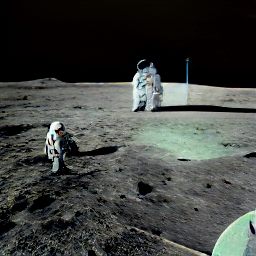

In [8]:
generate_image('People walking on the moon')

In [9]:
# We cheeck how much memory we after generating one image
if use_gpu == True : log_gpu_memory() 
temp='''
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |   7101MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
'''    

Tue Aug 30 12:51:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    34W /  70W |  14200MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
#We clean the memory used
wipe_memory()

In [11]:
log_gpu_memory() 

Tue Aug 30 12:51:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    34W /  70W |  13804MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

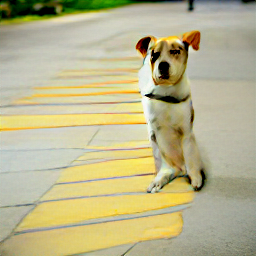

In [12]:
generate_image('Dog on the street')

In [13]:
log_gpu_memory() 

Tue Aug 30 12:51:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P0    34W /  70W |  14200MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
#We clean the memory used
wipe_memory()

In [15]:
text='Once, there was a girl called Laura who went to the supermarket to buy the ingredients to make a cake. Because today is her birthday and her friends come to her house and help her to prepare the cake.'

In [16]:
inputs = tokenizer(text, 
                max_length=1024, 
                truncation=True,
                return_tensors="pt") 
summary_ids = model.generate(inputs["input_ids"])
summary = tokenizer.batch_decode(summary_ids, 
                              skip_special_tokens=True, 
                              clean_up_tokenization_spaces=False)
plot = list(summary[0].split('.'))

For the sentence:
  Once, Laura went to the supermarket to buy the ingredients to make a cake 


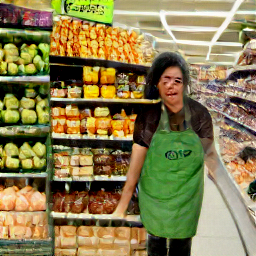

For the sentence:
  Her friends come to her house and help her to prepare the cake 


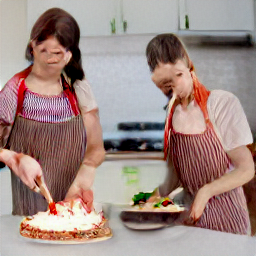

For the sentence:
  Because today is her birthday, she has friends help her prepare it for her birthday 


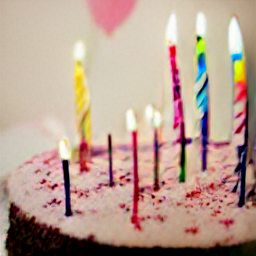

For the sentence:
  Laura's friends come and help prepare her to make her birthday cake 


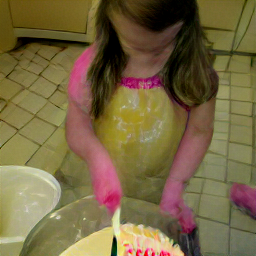

In [32]:
generated_images = []
for senten in plot[:-1]:
    if use_gpu == True : 
        torch.cuda.empty_cache() 
        gc.collect()
    image= generate_image(senten)
    print('For the sentence:\n',senten)
    display(image)
    #if use_gpu == True : log_gpu_memory() 
    generated_images.append(image)

In [33]:
# Step 4- Creation of the subtitles
sentences =plot[:-1]
num_sentences=len(sentences)
assert len(generated_images) == len(sentences) , print('Something is wrong')
#We can generate our list of subtitles
from nltk import tokenize
c = 0
sub_names = []
for k in range(len(generated_images)): 
    subtitles=tokenize.sent_tokenize(sentences[k])
    sub_names.append(subtitles)

In [34]:
# Step 5- Adding Subtitles to the Images
def draw_multiple_line_text(image, text, font, text_color, text_start_height):
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    y_text = text_start_height
    lines = textwrap.wrap(text, width=40)
    for line in lines:
        line_width, line_height = font.getsize(line)
        draw.text(((image_width - line_width) / 2, y_text), 
                  line, font=font, fill=text_color)
        y_text += line_height

In [35]:
def add_text_to_img(text1,image_input):
    '''
    Testing draw_multiple_line_text
    '''
    image =image_input
    fontsize = 13  # starting font size
    path_font="Roboto-Regular.ttf"
    font = ImageFont.truetype(path_font, fontsize)
    text_color = (255,255,0)
    text_start_height = 200
    draw_multiple_line_text(image, text1, font, text_color, text_start_height)
    return image

In [36]:
generated_images_sub = []
for k in range(len(generated_images)): 
    imagenes = generated_images[k].copy()
    text_to_add=sub_names[k][0]
    result=add_text_to_img(text_to_add,imagenes)
    generated_images_sub.append(result)

In [37]:
# Step  7 - Creation of audio 
c = 0
mp3_names = []
mp3_lengths = []
for k in range(len(generated_images)):
    text_to_add=sub_names[k][0]
    print(text_to_add)
    f_name = 'audio_'+str(c)+'.mp3'
    mp3_names.append(f_name)
    # The text that you want to convert to audio
    mytext = text_to_add
    # Language in which you want to convert
    language = 'en'
    # Passing the text and language to the engine,
    # here we have marked slow=False. Which tells
    # the module that the converted audio should
    # have a high speed
    myobj = gTTS(text=mytext, lang=language, slow=False)
    # Saving the converted audio in a mp3 file named
    sound_file=f_name
    myobj.save(sound_file)
    audio = MP3(sound_file)
    duration=audio.info.length
    mp3_lengths.append(duration)
    print(audio.info.length)
    c+=1

 Once, Laura went to the supermarket to buy the ingredients to make a cake
5.232
 Her friends come to her house and help her to prepare the cake
4.152
 Because today is her birthday, she has friends help her prepare it for her birthday
5.544
 Laura's friends come and help prepare her to make her birthday cake
4.536


In [38]:
#import sys
#sys.path.append('/home/ec2-user/SageMaker/How-to-run-Gradio-on-SageMaker-Notebook/Sagemaker/ffmpeg-5.0.1-amd64-static')
#sys.path.append('/usr/bin/ffprobe')

In [39]:
# Step 8 - Merge audio files
cwd = (getcwd()).replace(chr(92), '/')
#export_path = f'{cwd}/result.mp3'
export_path ='result.mp3'
MP3_FILES = glob.glob(pathname=f'{cwd}/*.mp3', recursive=True)
silence = AudioSegment.silent(duration=500)
full_audio = AudioSegment.empty()    # this will accumulate the entire mp3 audios
for n, mp3_file in enumerate(mp3_names):
    mp3_file = mp3_file.replace(chr(92), '/')
    print(n, mp3_file)
    # Load the current mp3 into `audio_segment`
    audio_segment = AudioSegment.from_mp3(mp3_file)
    # Just accumulate the new `audio_segment` + `silence`
    full_audio += audio_segment + silence
    print('Merging ', n)
# The loop will exit once all files in the list have been used
# Then export    
full_audio.export(export_path, format='mp3')
print('\ndone!')

0 audio_0.mp3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Merging  0
1 audio_1.mp3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

In [40]:
# Step 9 - Creation of the video with adjusted times of the sound
c = 0
file_names = []
for img in generated_images_sub:
    f_name = 'img_'+str(c)+'.jpg'
    file_names.append(f_name)
    img = img.save(f_name)
    c+=1
print(file_names)
clips=[]
d=0
for m in file_names:
    duration=mp3_lengths[d]
    print(d,duration)
    clips.append(ImageClip(m).set_duration(duration+0.5))
    d+=1
concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("result_new.mp4", fps=24)

['img_0.jpg', 'img_1.jpg', 'img_2.jpg', 'img_3.jpg']
0 5.232
1 4.152
2 5.544
3 4.536
[MoviePy] >>>> Building video result_new.mp4
[MoviePy] Writing video result_new.mp4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 516/516 [00:00<00:00, 1417.23it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: result_new.mp4 



In [41]:
# Step 10 - Merge Video + Audio
movie_name = 'result_new.mp4'
export_path='result.mp3'
movie_final= 'result_final.mp4'
def combine_audio(vidname, audname, outname, fps=60): 
    import moviepy.editor as mpe
    my_clip = mpe.VideoFileClip(vidname)
    audio_background = mpe.AudioFileClip(audname)
    final_clip = my_clip.set_audio(audio_background)
    final_clip.write_videofile(outname,fps=fps)
combine_audio(movie_name, export_path, movie_final) # create a new file

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 475/475 [00:00<00:00, 1320.98it/s]

[MoviePy] Done.
[MoviePy] Writing video result_final.mp4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|█████████▉| 1290/1291 [00:00<00:00, 1828.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: result_final.mp4 



In [42]:
from IPython.display import HTML
from base64 import b64encode
import os
# Show video
mp4 = open('result_final.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
